## 短期资产收益趋势预测

- 1. 选择感兴趣的标的资产：股票、ETF、加密货币、大宗商品，不要选择外汇（英镑兑美元），市场价值超过700亿美元的股票
- 2. 短期资产收益趋势预测（日，6小时），通过二项分类预测（0，1或者1，-1）

需要设计：如何分类极小接近于0的收益（从测试样本中删除，通过positive/negative分组）。划分标准非常依赖标的资产。

In [98]:
# SP500
# 只做参考用，资产太大了，不符合作业要求

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score

# Classifier
from sklearn.tree import DecisionTreeClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix, auc, roc_curve, plot_roc_curve

pd.set_option('display.float_format',lambda x : '%.4f' % x)

In [99]:
spx = pd.read_excel('SP500.xlsx', index_col=0, parse_dates=True)['2015':]
spx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,2058.8999,2072.3601,2046.0400,2058.2000,2058.2000,2708700000
2015-01-05,2054.4399,2054.4399,2017.3400,2020.5800,2020.5800,3799120000
2015-01-06,2022.1500,2030.2500,1992.4399,2002.6100,2002.6100,4460110000
2015-01-07,2005.5500,2029.6100,2005.5500,2025.9000,2025.9000,3805480000
2015-01-08,2030.6100,2064.0801,2030.6100,2062.1399,2062.1399,3934010000


In [100]:
# 因子库

spx['O-C'] = spx['Open'] - spx['Close']
spx['H-L'] = spx['High'] - spx['Low']

spx['Log_Return'] = np.log(spx['Adj Close']).diff()

spx['Sign'] = np.sign(spx['Log_Return'])

spx['Pass_Returns_3'] = spx['Log_Return'].diff(3)
spx['Pass_Returns_5'] = spx['Log_Return'].diff(5)
spx['Pass_Returns_10'] = spx['Log_Return'].diff(10)

# 动量指标
spx['Momentum_3'] = spx['Adj Close'].diff(3)
spx['Momentum_5'] = spx['Adj Close'].diff(5)
spx['Momentum_10'] = spx['Adj Close'].diff(10)

# 移动平均
spx['SMA_3'] = spx['Adj Close'].rolling(3).mean()
spx['SMA_5'] = spx['Adj Close'].rolling(5).mean()
spx['SMA_10'] = spx['Adj Close'].rolling(10).mean()


# EMA（Exponential Moving Average）是指数移动平均值。也叫 EXPMA 指标，它也是一种趋向类指标，指数移动平均值是以指数式递减加权的移动平均。
alpha = 2/(spx.shape[0] + 1)
spx['EMA'] = spx['Adj Close'].ewm(alpha = alpha, adjust = False).mean()

spx

,Open,High,Low,Close,Adj Close,Volume,O-C,H-L,Log_Return,Sign,Pass_Returns_3,Pass_Returns_5,Pass_Returns_10,Momentum_3,Momentum_5,Momentum_10,SMA_3,SMA_5,SMA_10,EMA
Date,,,,,,,,,,,,,,,,,,,,
2015-01-02,2058.8999,2072.3601,2046.0400,2058.2000,2058.2000,2708700000,0.7000,26.3201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2058.2000
2015-01-05,2054.4399,2054.4399,2017.3400,2020.5800,2020.5800,3799120000,33.8600,37.1000,-0.0184,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2058.1505
2015-01-06,2022.1500,2030.2500,1992.4399,2002.6100,2002.6100,4460110000,19.5400,37.8101,-0.0089,-1.0000,NaN,NaN,NaN,NaN,NaN,NaN,2027.1300,NaN,NaN,2058.0775
2015-01-07,2005.5500,2029.6100,2005.5500,2025.9000,2025.9000,3805480000,-20.3500,24.0599,0.0116,1.0000,NaN,NaN,NaN,-32.2999,NaN,NaN,2016.3633,NaN,NaN,2058.0352
2015-01-08,2030.6100,2064.0801,2030.6100,2062.1399,2062.1399,3934010000,-31.5299,33.4701,0.0177,1.0000,0.0362,NaN,NaN,41.5599,NaN,NaN,2030.2166,2033.8860,NaN,2058.0406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-11,3803.1399,3817.8601,3789.0200,3799.6101,3799.6101,4450500000,3.5298,28.8401,-0.0066,-1.0000,-0.0123,0.0083,-0.0101,51.4702,98.9602,96.5500,3809.3600,3780.6160,3755.4240,2720.7811
2021-01-12,3801.6201,3810.7800,3776.5100,3801.1899,3801.1899,4977210000,0.4302,34.2700,0.0004,1.0000,-0.0143,-0.0066,-0.0083,-2.6001,74.3298,65.8298,3808.4933,3795.4820,3762.0070,2722.2008
2021-01-13,3802.2300,3820.9600,3791.5000,3809.8401,3809.8401,4590420000,-7.6101,29.4600,0.0023,1.0000,-0.0032,-0.0034,0.0045,-14.8398,61.7002,82.8000,3803.5467,3807.8220,3770.2870,2723.6300


In [101]:
factors = spx.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1)
factors['Sign'] = factors['Sign'].shift(-1)
factors = factors.dropna()
factors

,Adj Close,O-C,H-L,Log_Return,Sign,Pass_Returns_3,Pass_Returns_5,Pass_Returns_10,Momentum_3,Momentum_5,Momentum_10,SMA_3,SMA_5,SMA_10,EMA
Date,,,,,,,,,,,,,,,
2015-01-20,2022.5500,-1.7900,24.4500,0.0015,1.0000,0.0074,0.0097,0.0200,11.2800,-5.7100,1.9701,2011.5467,2013.7880,2023.2660,2057.6945
2015-01-21,2032.1200,-11.9301,26.2500,0.0047,1.0000,0.0140,0.0073,0.0137,39.4500,9.0900,29.5100,2024.6967,2015.6060,2026.2170,2057.6609
2015-01-22,2063.1499,-28.8499,38.2401,0.0152,-1.0000,0.0018,0.0210,0.0036,43.7299,51.8799,37.2499,2039.2733,2025.9820,2029.9420,2057.6681
2015-01-23,2051.8201,11.1599,12.4399,-0.0055,1.0000,-0.0071,0.0038,-0.0232,29.2700,59.1500,-10.3198,2049.0300,2037.8120,2028.9100,2057.6605
2015-01-26,2057.0901,-6.6702,16.6501,0.0026,-1.0000,-0.0022,-0.0108,0.0110,24.9701,37.6700,12.2800,2057.3534,2045.3460,2030.1380,2057.6597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-08,3824.6799,-9.6299,43.0898,0.0055,-1.0000,-0.0016,-0.0009,0.0047,97.8198,68.6099,134.6699,3792.2033,3760.8240,3745.7690,2719.3616
2021-01-11,3799.6101,3.5298,28.8401,-0.0066,1.0000,-0.0123,0.0083,-0.0101,51.4702,98.9602,96.5500,3809.3600,3780.6160,3755.4240,2720.7811
2021-01-12,3801.1899,0.4302,34.2700,0.0004,1.0000,-0.0143,-0.0066,-0.0083,-2.6001,74.3298,65.8298,3808.4933,3795.4820,3762.0070,2722.2008


In [102]:
factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1509 entries, 2015-01-20 to 2021-01-14
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Adj Close        1509 non-null   float64
 1   O-C              1509 non-null   float64
 2   H-L              1509 non-null   float64
 3   Log_Return       1509 non-null   float64
 4   Sign             1509 non-null   float64
 5   Pass_Returns_3   1509 non-null   float64
 6   Pass_Returns_5   1509 non-null   float64
 7   Pass_Returns_10  1509 non-null   float64
 8   Momentum_3       1509 non-null   float64
 9   Momentum_5       1509 non-null   float64
 10  Momentum_10      1509 non-null   float64
 11  SMA_3            1509 non-null   float64
 12  SMA_5            1509 non-null   float64
 13  SMA_10           1509 non-null   float64
 14  EMA              1509 non-null   float64
dtypes: float64(15)
memory usage: 188.6 KB


In [103]:
factors.describe().T

,count,mean,std,min,25%,50%,75%,max
Adj Close,1509.0000,2591.9575,459.9241,1829.0800,2128.2800,2599.0300,2896.7200,3824.6799
O-C,1509.0000,-0.2718,23.0748,-141.0300,-10.4700,-1.0999,7.1599,150.2202
H-L,1509.0000,27.2533,23.7639,3.7900,13.0300,19.9399,32.5601,218.9600
Log_Return,1509.0000,0.0004,0.0118,-0.1277,-0.0031,0.0006,0.0053,0.0897
Sign,1509.0000,0.0901,0.9959,-1.0000,-1.0000,1.0000,1.0000,1.0000
Pass_Returns_3,1509.0000,0.0000,0.0168,-0.1420,-0.0069,-0.0005,0.0060,0.1582
Pass_Returns_5,1509.0000,0.0000,0.0160,-0.1331,-0.0070,-0.0003,0.0066,0.1060
Pass_Returns_10,1509.0000,0.0000,0.0173,-0.1727,-0.0066,-0.0001,0.0067,0.1606
Momentum_3,1509.0000,3.5674,49.3368,-383.5601,-13.6201,6.0701,25.8401,392.6702
Momentum_5,1509.0000,5.9352,63.4407,-543.3000,-14.7500,10.1699,35.0200,389.2500


array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

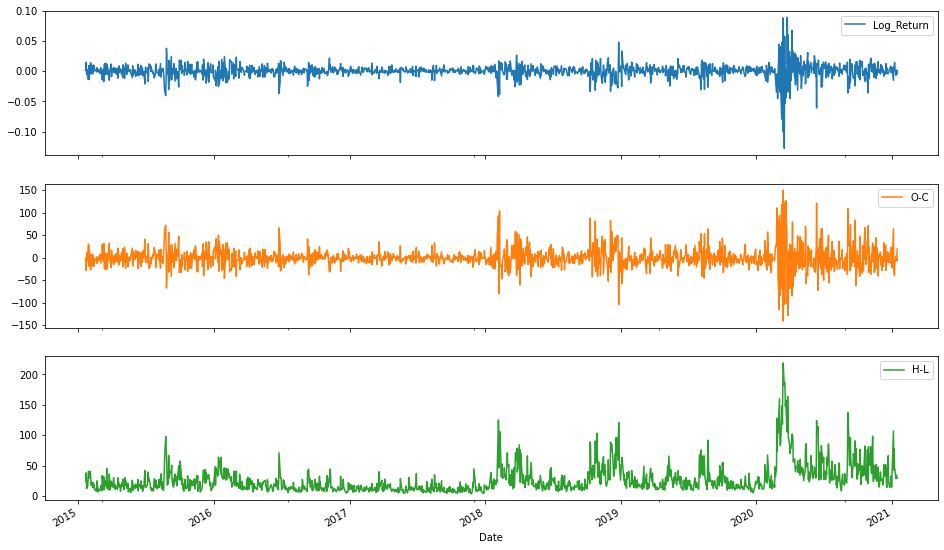

In [104]:
factors.plot(y=['Log_Return', 'O-C', 'H-L'], subplots=True, figsize=(16, 10))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

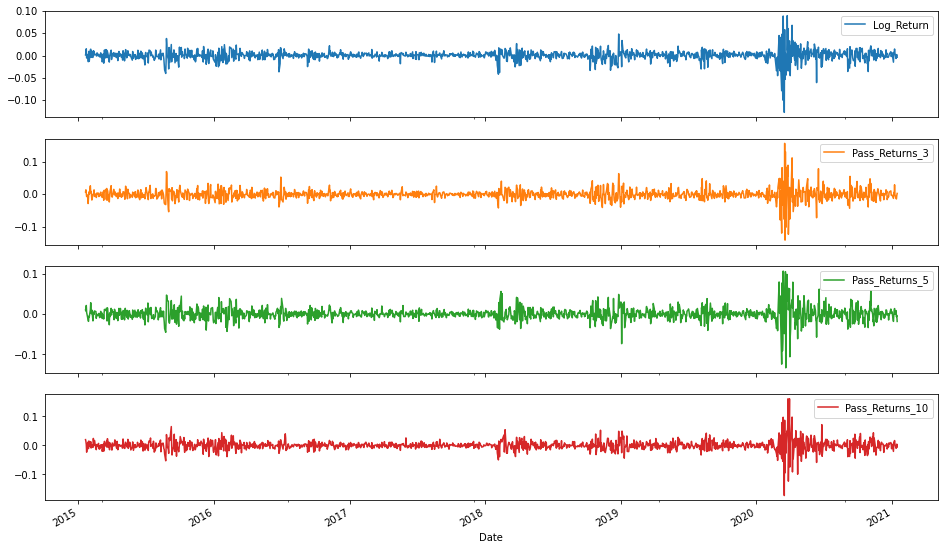

In [105]:
factors.plot(y=['Log_Return', 'Pass_Returns_3', 'Pass_Returns_5', 'Pass_Returns_10'], subplots=True, figsize=(16, 10))

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

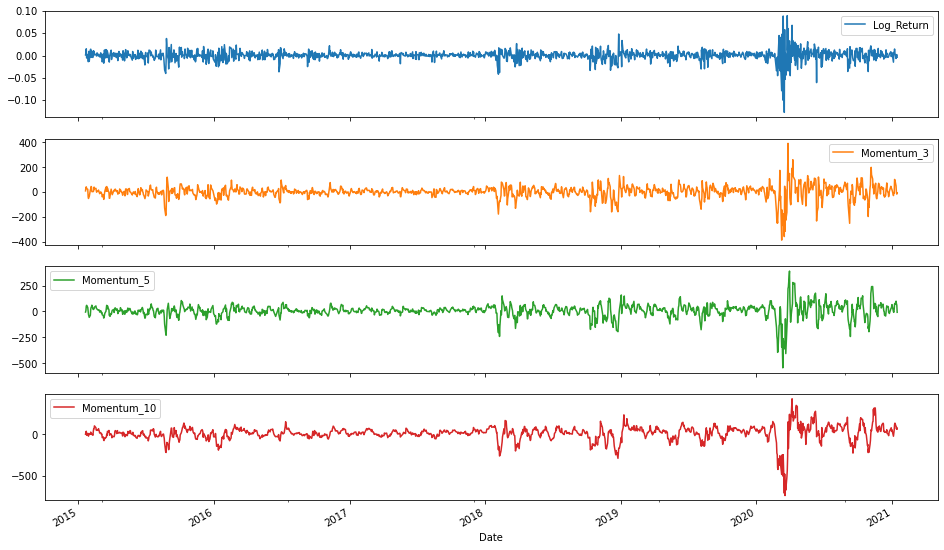

In [106]:
factors.plot(y=['Log_Return', 'Momentum_3', 'Momentum_5', 'Momentum_10'], subplots=True, figsize=(16, 10))

<AxesSubplot:xlabel='Date'>

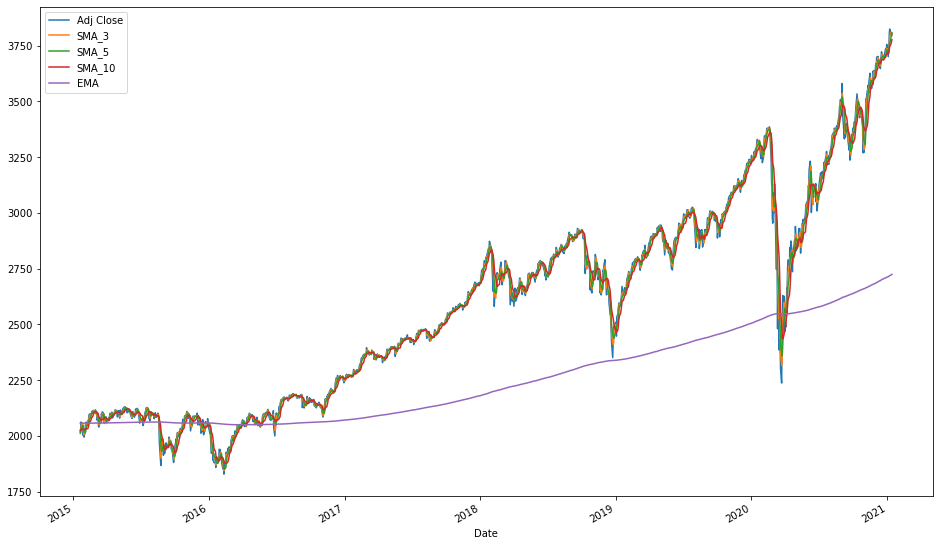

In [107]:
factors.plot(y=['Adj Close', 'SMA_3', 'SMA_5', 'SMA_10', 'EMA'], figsize=(16, 10))

In [108]:
X = factors.drop('Sign', axis=1).values
y = factors['Sign'].values

In [109]:
X

array([[ 2.02255005e+03, -1.79003900e+00,  2.44499510e+01, ...,
         2.01378804e+03,  2.02326602e+03,  2.05769454e+03],
       [ 2.03212000e+03, -1.19300540e+01,  2.62500000e+01, ...,
         2.01560603e+03,  2.02621702e+03,  2.05766093e+03],
       [ 2.06314990e+03, -2.88498530e+01,  3.82401120e+01, ...,
         2.02598201e+03,  2.02994200e+03,  2.05766815e+03],
       ...,
       [ 3.80118994e+03,  4.30176000e-01,  3.42700190e+01, ...,
         3.79548198e+03,  3.76200701e+03,  2.72220080e+03],
       [ 3.80984009e+03, -7.61010800e+00,  2.94599610e+01, ...,
         3.80782202e+03,  3.77028701e+03,  2.72363003e+03],
       [ 3.79554004e+03,  1.94399410e+01,  3.07399910e+01, ...,
         3.80617202e+03,  3.77663701e+03,  2.72503858e+03]])

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 1207, 302


In [111]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier())
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', DecisionTreeClassifier())])

In [112]:
y_pred = pipe.predict(X_test)
y_pred

array([ 1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,
        1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1., -1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1., -1.,  1.,
       -1., -1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1., -1.,  1

In [113]:
acc_train = accuracy_score(y_train, pipe.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 1.0, Test Accuracy: 0.5331


In [114]:
probs = pipe.predict_proba(X_test)
probs

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0

In [115]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('classifier', DecisionTreeClassifier())],
 'verbose': False,
 'scaler': StandardScaler(),
 'classifier': DecisionTreeClassifier(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'gini',
 'classifier__max_depth': None,
 'classifier__max_features': None,
 'classifier__max_leaf_nodes': None,
 'classifier__min_impurity_decrease': 0.0,
 'classifier__min_impurity_split': None,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 2,
 'classifier__min_weight_fraction_leaf': 0.0,
 'classifier__random_state': None,
 'classifier__splitter': 'best'}

In [123]:
param_grid = {
    'classifier__criterion': ["gini", "entropy"],
    'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 30, 40, 50],
    'classifier__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'classifier__random_state': [0, 1, 2, 3, 4, 5, 10, 15, 20, 35, 50, 80, 100, 150, 180, 200],
}
grid_search = GridSearchCV(
    pipe, param_grid, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
best_model = grid_search.fit(X, y)


Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [124]:
best_model.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 4,
 'classifier__max_features': 1,
 'classifier__random_state': 5}

In [127]:
param_new = {'classifier__criterion': 'entropy',
             'classifier__max_depth': 4,
             'classifier__max_features': 1,
             'classifier__random_state': 5}

pipe_new = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(criterion='entropy',
                                          max_depth=4,
                                          max_features=1,
                                          random_state=5))
])

pipe_new.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4,
                                        max_features=1, random_state=5))])

In [128]:
y_pred_new = pipe_new.predict(X_test)
y_pred_new

array([ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [129]:
acc_train = accuracy_score(y_train, pipe_new.predict(X_train))
acc_test = accuracy_score(y_test, y_pred_new)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.5857, Test Accuracy: 0.606
